训练集Accuracy:  0.8346456692913385
测试集Accuracy:  0.6956521739130435


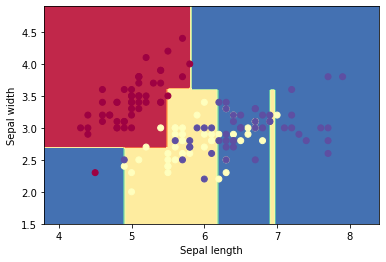

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter
import math

# 设置随机种子
seed_value = 2023
np.random.seed(seed_value)

# 定义节点
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index  
        self.threshold = threshold  
        self.left = left  
        self.right = right  
        self.value = value  

# 定义决策树模型
class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth # 决策树深度

    # 模型训练
    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    # 模型预测
    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X])

    # 预测节点类型
    def _predict(self, inputs):
        node = self.tree_
        while node.value is None:
            if inputs[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    # 生成树
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(set(y))

        if depth >= self.max_depth or n_labels == 1 or n_samples < 2:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feature_indices = range(n_features)
        best_feature, best_threshold = self._best_criteria(X, y, feature_indices)
        left_indices, right_indices = self._split(X[:, best_feature], best_threshold)

        left = self._grow_tree(X[left_indices, :], y[left_indices], depth + 1)
        right = self._grow_tree(X[right_indices, :], y[right_indices], depth + 1)
        return Node(best_feature, best_threshold, left, right)

    # 信息增益最大的特征和阈值
    def _best_criteria(self, X, y, feature_indices):
        best_gain = -1
        split_index, split_threshold = None, None
        for i in feature_indices:
            column = X[:, i]
            thresholds = set(column)
            for threshold in thresholds:
                gain = self._information_gain(y, column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_index = i
                    split_threshold = threshold
        return split_index, split_threshold

    # 信息增益
    def _information_gain(self, y, X_column, split_threshold):
        parent_entropy = self._entropy(y)
        left_indices, right_indices = self._split(X_column, split_threshold)
        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0
        n = len(y)
        nl, nr = len(left_indices), len(right_indices)
        el = self._entropy(y[left_indices])
        er = self._entropy(y[right_indices])
        child_entropy = (nl / n) * el + (nr / n) * er
        ig = parent_entropy - child_entropy
        return ig

    # 熵
    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / np.sum(hist)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    # 分割节点
    def _split(self, X_column, split_threshold):
        left_indices = np.argwhere(X_column <= split_threshold).flatten()
        right_indices = np.argwhere(X_column > split_threshold).flatten()
        return left_indices, right_indices

    # 返回标签
    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common
    
    # 精度
    def score(self, y_pred, y):
        accuracy = (y_pred == y).sum() / len(y)
        return accuracy

# 导入数据
X, y = load_iris(return_X_y=True)
X = X[:, :2]

# 划分训练集、测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed_value)

# 训练决策树
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)

# 结果
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

score_train = model.score(y_train_pred, y_train)
score_test = model.score(y_test_pred, y_test)

print('训练集Accuracy: ', score_train)
print('测试集Accuracy: ', score_test)

# 可视化决策边界
x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)
plt.contourf(xx1, xx2, Z, cmap=plt.cm.Spectral)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.savefig('a.png', dpi=720)
plt.show()
